# 개요

* 아래의 목적/이유로 참가한 스터디에 대한 기록
  * SQLD취득 후 장기 미사용 & GPT를 통한 SQL사용 등으로 많이 잊은 SQL을 복기
  * 기존에 사용해 본 Optuna가 아닌 Autogluon이 커리큘럼에 있어 익혀보고자 함
  * 기존에 관심있던 XAI(설명가능한 AI)를 익히고자 함

* 4주차 요약
  * 불균형 처리기법 - Under/Over/Hybrid Sampling
  * 파생변수
  * 모델선택(불균형처리, 가중치조절 등)

# 3주차 과제 내용정리

* Skew한 데이터는 mean보다는 median으로 대체하는 것이 효과가 좋을 때가 많았음
  * 구체적인 사유가 확인되었다기보다는 실험적인 부분
* 데이터의 의미가 없는 경우, Drop하여 메모리 절약하는 것이 나음
* Encoder의 저장과 `inverse_transform`(숫자로 변환된 범주형변수의 원래값 반환)
```python
le = LabelEncoder()
le.fit_transform(column)
le.inverse_transform([0,1,2,3])
```

# 4주차 수업정리

## 불균형 데이터 처리

* 불균형이 많은 금융데이터의 경우, 단순히 하나의 값만 예측해내더라도 accuracy는 99%가 될 수 있음
  * 하지만 목표는 1%의 사기/이상 데이터를 찾아내는 것임
  * 이러한 문제를 막기위해 불균형 데이터의 처리가 필요함

* 불균형데이터의 처리 방법
  * 데이터 수준 방법(학습전 데이터 처리)
    * Under-Sampling : RUS, Tomek Links, ENN 등
    * Over-Sampling : SMOTE, ADASYN 등
    * Hybrid Method : SMOTETomek(SMOTE-Tomek), SMOTEENN(SMOTE-ENN)
  * 알고리즘 수준 방법(학습시 가중치 조정)
    * 가중치 조정


### 불균형 데이터 처리(데이터수준) - Under-Sampling

* `Under-Sampling` : 수가 더 많은 class의 값을 **줄이는 것**
* Under-Sampling 종류
  * `RUS(Random Under Sampling)` : 랜덤하게 제거
    * 데이터가 커지면 알고리즘적 방법 적용이 어려워,1차적으로 많이 사용됨
    * 파이썬에서도 빠르게 가능하며, SQL에서는 더 빠르게 가능(ORDER BY RAND() LIMIT)
  * `ENN(Edited Nearest Neighbors)` : KNN알고리즘 기반의 노이즈 제거
    * 근접한 N개의 class분포 내에서, 해당 class와 다른 값을 제거
    * 데이터의 분포가 정돈되는 효과
    * 정확한 비율을 설정할수는 없음
  * `Tomeklinks` : class의 경계를 기반으로 노이즈 제거
    * 클러스터링 한 2개의 그룹에서, 알고리즘으로 경계를 찾아서, 많은 쪽의 class를 제거
    * 경계선 구분이 명확해지는 효과
* Under-Sampling 방법별 결과 비교
  * RUS : 수가 많은 class 임의 제거
  * ENN : 오분류로 추정되는 값 제거 (예:주황색 그룹 안의 파란점 제거)
  * Tomeklinks : 경계선에 있는 값 제거 (경계를 찾아낸 후, 경계에서 많은 점을 제거)
  * 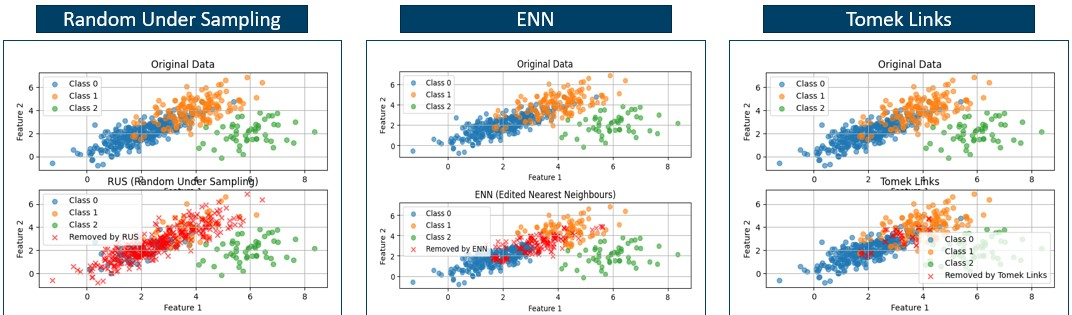


### 불균형 데이터 처리(데이터수준) - Over-Sampling

* `Over-Sampling` : 수가 적은 class의 값 **늘리는 것**
  * 아래의 사유들로, 잘 쓰이지 않음
    * 전반적으로 과적합 위험이 있으며, 삭제가 아닌 생성으로 시간이 오래 걸림
* Over-Sampling 종류
  * `ROS(Random Over Sampling)` : (RUS와 같이) 랜덤하게 제거
    * 실제로 쓰이지는 않으며, 빠르지만 **과적합의 위험**
  * `SMOTE` : KNN알고리즘 기반, 인접한 이웃과의 선형보간을 통한 데이터 생성
    * 기존 데이터의 단순 재생산이 아니므로 (상대적으로) 과적합 위험 적음
  * `ADASYN` : SMOTE의 개량형. 학습이 어려운 샘플(분류상 경계에 있는)에 더 많은 데이터를 생성
    * (Tomeklink와 유사하게)경계 근처의 데이터에 더 많은 샘플을 생성
      * SMOTE에 Weight를 추가한 개념(구분이 어려운 경계 근처 샘플에 Weight를 더 줌)
    * 경계 구분이 어려울 때 이점. 그러나 특정 데이터에 과적합될 위험
* Over-Sampling 방법별 결과 비교
  * ROS : 수가 적은 CLASS 임의 추가
  * SMOTE : (ROS와 달리)기존 분포를 어느정보 반영하여 추가 (SMOTE알고리즘 활용)
  * ADASYN : 경계선에 걸친 값 위주로 값 추가 (ADASYN알고리즘 활용)
  * 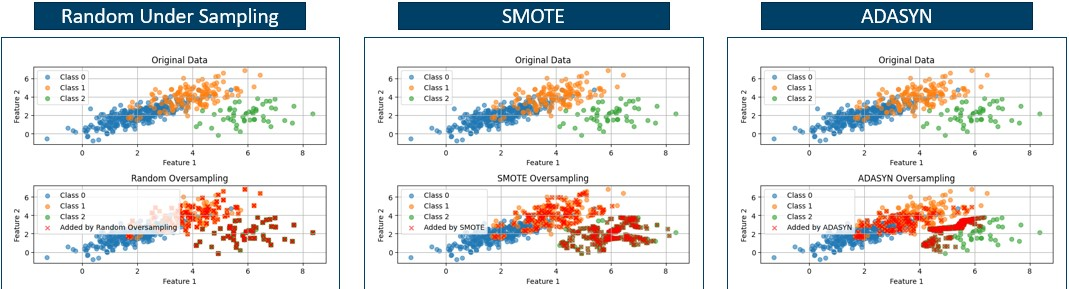


### 불균형 데이터 처리(데이터수준) - Hybrid Method

* `Hybrid Method` : Over와 Under Sampling을 합친 Combined Method
* Hybrid Method의 종류
  * `SMOTETomeks` : SMOTE로 소수 클래스 증강 후, Tomeklinks로 제거
    * 경계가 뚜렷하지 않은 경우에 적합
    * SMOTE + Tomeklinks
  * `SMOTEEN` : SMOTE로 소수 클래스 증강 후, ENN으로 제거
    * 경계 근처에 노이즈가 많은 경우 적합
    * SMOTE + ENN
* ADASYN이 아닌, SMOTE로 먼저 보강하는 이유
  * (ADASYN에 비해) SMOTE가 간단히/직관적으로 데이터를 증강해 안정적
  * 소수 클래스에 대한 균일한 보강으로(ADASYN은 경계값 위주), 일관적인 성능 발휘
    * Test데이터의 적중이 목표이므로 Train과적합이 ADASYN보다 SMOTE가 덜함
  * 오래/넓게 쓰여왔던 방법론으로, 선호도가 높음
* Hybrid Method 방법별 결과 비교
  * SMOTETomeks : 제거된 값이 주로 경계에 모여있음
  * SMOTEEN : 제거된 값이 경계 이외에도, 노이즈들에 해당
  * 추가를 의미하는 파란점은 유사하고[SMOTE공통사용]. 삭제를 의미하는 빨간점은 분포가 다름<br>
    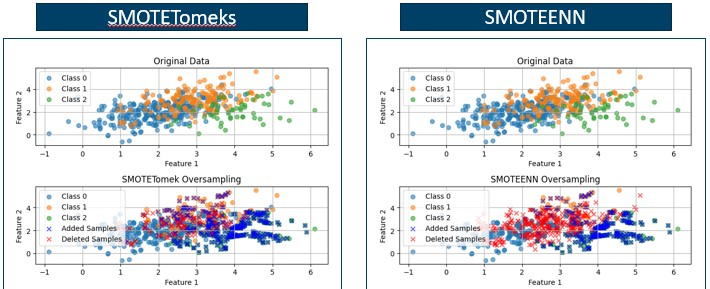


### 불균형 데이터 처리(알고리즘 수준) - 가중치 조절

* `가중치 조절` : 데이터 수정시가 아닌, 알고리즘 학습시에 가중치를 조절
  * 데이터 수준에서의 처리(Oversampling 등)는 시간이 오래걸리므로 학습시 처리하자는 관점
  * 데이터 처리를 하지 않아도 된다는 장점이 있어, 실제로 많이 사용
  * 가중치는 분석가의 직감이 아닌, 데이터의 비중을 참고하여 반영(a가 b보다 10배많다면 b에 가중치 10 부여)
  * 불균형이 극단적인 경우, 데이터 처리(Oversampling 등)로 비율을 맞춘 후 가중치부여
* Logloss 예시
  * $y_i$와 $(1 - y_i)$ 앞에 가중치를 두고, 더 중요한 부분에 가중치를 높게 설정
  * **조정 전 Logloss**
    $$\text{LogLoss} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]$$
  * **조정 후 Logloss** : Class가중치(Class weight)인 $w0$, $w1$을 추가
    $$\text{Weighted LogLoss} = -\frac{1}{N} \sum_{i=1}^{N} \left[ \omega_1 \cdot y_i \cdot \log(\hat{y}_i) + \omega_0 \cdot (1 - y_i) \cdot \log(1 - \hat{y}_i) \right]$$
  * 1일 때 $w1$, 0일 때 $w0$을 곱해 가중치를 부여했음

## 파생변수

* `파생변수` : 기존 데이터에서 새로운 정보를 추출하여 생성한 변수
  * **EDA 후 파생변수 생성이 필요하다고 판단**될 때, **데이터 전처리를 완료**한 후 진행
    * 전처리전 파생변수를 만들면, 전처리할 양도 많아지고 오래걸리게 됨
  * 전처리시 진행했던 변환, 인코딩, 군집화도 파생변수의 일종
  * **도메인 지식이 매우 중요함함**
* 파생변수의 유형
  * `집계 관련 변수` : 추가적인 집계가 필요하다면, SQL 등을 통해 생성 가능
    * 특정 집단/기간 등을 기준으로 추가할 수 있음
    * 연령별 평균 교통비 등의 변수. 보통 SQL에서 처리하여 가져옴
  * `날짜 관련 변수` : 시간/요일/휴일/공휴일 등을 추가
    * 요일, 휴일 등의 경우 도움이 될 수 있음
      * 예를 들어, 물동량 예측시 요일의존도가 높은데, 날짜기반으로 전주대비 물동량 차이 등을 파생변수로
      * 
  * `상호작용 변수` : 변수간의 상호작용 가능 & 본인의 도메인지식이 충분한 경우, SQL 등으로 생성가능
    * Polynomial Interation(오래된 통계모델링 코드 등에서 보임)
      * 변수 간 상호작용에서 발생하는 비선형적 관계를 설명하기 위해, 기존 변수들의 곱을 변수로 추가한 것. 기존 통계적 모델링에서 활용됨
      * 차원의 저주에 쉽게 빠지는 단점과, 트리기반 모델에서 자체적으로 비선형관계를 처리하는 등(다중공선성 문제에서 자유롭다) ML로 넘어오며 **이제는 거의 사용되지 않음**
        * 트리 기반 모델이 Best가 되며 다중공선성은 덜 고려해도되지 않나 하는 경향이 있음
      *  `sklearn.preprocessing`으로 가능

## 모델 선택

* 모델 선택 : 유형에 따라 적절한 모델을 선택해야 함.
  * 베이스라인 모델로 Regression 등을 먼저 돌려보기도 함
    * Regression모델이 계수로 나와 해석이 쉽고 보고하기 좋음, 다만 성능이 좋지 않음
* 모델 선택 유형
  * `문제 유형에 따른 분류` : 회귀 or 분류
    * `회귀` : 선형 회귀 등 `Regressor`로 끝나는 모델
    * `분류` : 로지스틱 회귀 등 `Classifier`로 끝나는 모델
  * `데이터 특성에 따른 분류` : 
    * 데이터 크기 : 데이터가 클수록 계산효율이 좋은 모델
      * 큰 데이터에 약한 SVM모델 vs 상대적으로 나은 트리 기반 모델
    * 데이터 형태 : 데이터에 선형성이 없는 경우, Linear모델 지양
      * 반대라면 빠르게 결과를 볼 수 있는 선형 모델 사용
  * `해석 가능성에 따른 분류` : 통계적 회귀모델 vs 트리기반 모델 vs SVM/DNN
    * 통계적 회귀모델 : 가장 해석이 쉬움
    * 트리기반 모델 : feature importance 반환으로 어느정도 해석 가능
    * SVN/DNN 모델 : 해석이 거의 불가한 Black box
* 모델별 장단점

    | 구분                | 선형/로지스틱 회귀                 | SVM                                  | 트리 기반 모델                                  |
    |----------------------|-----------------------------------------|---------------------------------------|--------------------------------------------------|
    | 해석 가능성         | 높음                                    | 매우 낮음                             | 낮음                                            |
    | 데이터 크기         | 소규모에서 효과적                      | 소규모에서 효과적                     | 대규모 데이터 처리 가능                         |
    | 데이터 전처리       | 고차원에서 매우 비효율적<br>다중공선성 등 취약               | 고차원 데이터에서 효율적<br>많은 컬럼에 강해 SOTA였음<br>많은 행은 어려움             | 상대적으로 고차원에서 나쁘지 않음             |
    | 정확 / 이상치       | 취약                                    | 취약                                   | 강건<br>(노드가 나뉘므로)                                            |
    | 학습 속도           | 빠름                                    | 데이터 크기가 클수록 급격하게 느림 | 보통                                            |
* 트리기반 모델 장단점 비교
  * LightGBM이 가장 빠르고, 이후는 병렬학습인 Bagging모델이 다음으로 빠름

      |구분|Random Forest|XGBoost|LightGBM|CATBOOST|Extra Trees|
      |-----|-----|-----|-----|-----|-----|
      |학습방식|Bagging<br>(다수 트리의 평균)|Boosting<br>(순차적트리학습)|Boosting<br>(순차적트리학습)|Boosting<br>(순차적트리학습)|Bagging<br>(다수 트리의 평균)|
      |속도|빠름|상대적으로 느림|가장 빠름|중간|빠름|
      |특성중요도|제공|제공|제공|제공|제공|
      |장점|가장 간단|(충분한 시간/리소스 있다면)성능이 뛰어감|가장 빠름/ 대규모 데이터처리에 능함|범주형 변수처리 특화. 자동처리 가능|RF에서 더 랜덤성을 강화하여 강건한 모델 생성|
      |단점|가장 간단|느리고 메모리소모 많음|메모리사용량 높음|일부 설정에서 느림|RF보다 성능 떨어지는 경우가 많음|
* 배깅(Bagging)과 부스팅(Boosting)
  * 보통은 부스팅이 이기는 경우가 많으며, 분산이 높고 불안정한 경우 배깅이 이기기도 함
  
      |구분|배깅(Bagging)|부스팅(Boosting)|
      |-|-|-|
      |개요|**여러 약한 모델의 결과**를 결합<br>→하나의 결과|**이전 약한 모델의 틀린 결과**를 개선하며<br>→순차적 학습|
      |학습방식|원본 데이터에서 **여러 하위집합(Bag)** 생성하고,<br>개별 Bag에 대해 **약한 모델이 병렬적으로 학습**됨|원본 데이터에서 **하위 집합**을 생성하고,기본 모델을 생성<br>해당 **기본모델로 예측 후** 틀린 예측에 더 높은 가중치를 부여하며 **점차 개선**|
      |특징|모델의 분산을 줄이고 **과적합을 피하는데** 도움<br>특히 **분산을 줄이는데 중점**|모델의 분산을 줄이고 **어려운 문제를 푸는데** 도움<br>특히 **편향을 줄이는데 중점**|
      |사용처|분류기가 불안정하고 분산이 높을 때 유용|모델의 안정성보다 문제 난이도가 어려울 때 유용|
* 배깅(Bagging)과 부스팅(Boosting)의 작동방식 차이<br>
    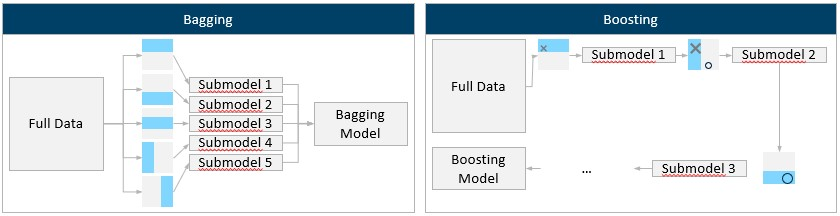

## 불균형데이터(Imbalnced Data) 처리 실습 (샘플데이터)

In [ ]:
# 샘플데이터 생성 : 3개 클래스의 2차원 데이터 생성 (더 겹치도록 분산 조정함)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

np.random.seed(42)
class_0 = np.random.multivariate_normal([2, 2], [[1, 0.8], [0.8, 1]], 300)
class_1 = np.random.multivariate_normal([4, 4], [[1, 0.6], [0.6, 1]], 150)
class_2 = np.random.multivariate_normal([6, 2], [[1, 0.5], [0.5, 1]], 50)

data = np.vstack([class_0, class_1, class_2])
labels = np.array([0] * 300 + [1] * 150 + [2] * 50)

df = pd.DataFrame(data, columns=["feature1", "feature2"])
df["TARGET"] = labels

# 원본 클래스 분포
original_counts = Counter(df["TARGET"])
original_counts

Counter({0: 300, 1: 150, 2: 50})

### Undersampling - RUS

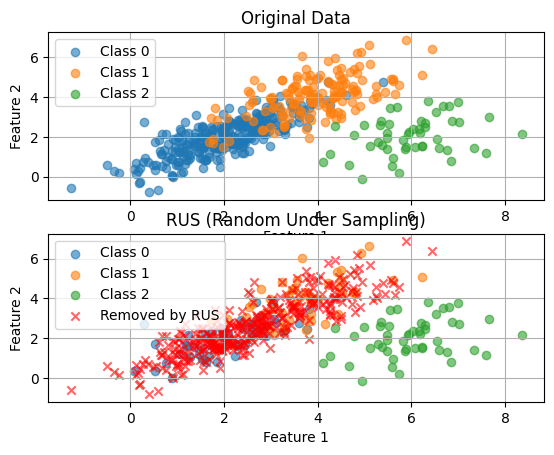

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# RUS 적용
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(df[["feature1", "feature2"]], df["TARGET"])

# RUS 제거된 데이터 계산
rus_removed = df.merge(pd.DataFrame(X_rus, columns=["feature1", "feature2"]), how="outer", indicator=True)
rus_removed = rus_removed[rus_removed["_merge"] == "left_only"]

# 시각화
# plt.figure(figsize=(3, 3))

# 원본 데이터
plt.subplot(2, 1, 1)
for target_class in original_counts.keys():
    subset = df[df["TARGET"] == target_class]
    plt.scatter(subset["feature1"], subset["feature2"], label=f"Class {target_class}", alpha=0.6)
plt.title("Original Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)

# RUS 데이터
plt.subplot(2, 1, 2)
for target_class in np.unique(y_rus):
    subset = pd.DataFrame(X_rus, columns=["feature1", "feature2"])[y_rus == target_class]
    plt.scatter(subset["feature1"], subset["feature2"], label=f"Class {target_class}", alpha=0.6)
plt.scatter(rus_removed["feature1"], rus_removed["feature2"], color="red", label="Removed by RUS", alpha=0.6, marker='x')
plt.title("RUS (Random Under Sampling)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)

### Undersampling - ENN

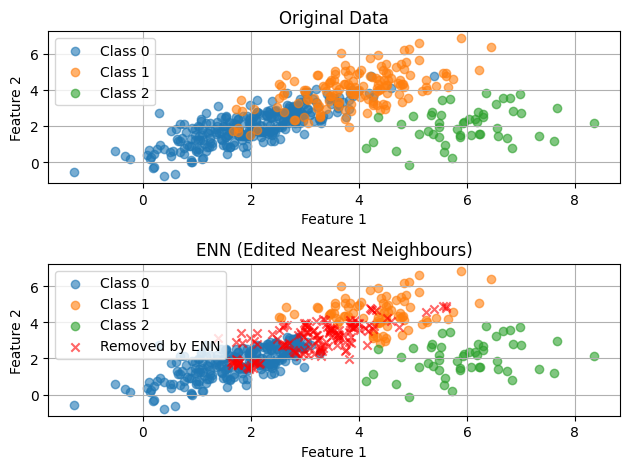

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours

# ENN 적용
enn = EditedNearestNeighbours()
X_enn, y_enn = enn.fit_resample(df[["feature1", "feature2"]], df["TARGET"])

# 제거된 데이터 계산
enn_removed = df.merge(pd.DataFrame(X_enn, columns=["feature1", "feature2"]), how="outer", indicator=True)
enn_removed = enn_removed[enn_removed["_merge"] == "left_only"]

# 원본 데이터
plt.subplot(2,1, 1)
for target_class in original_counts.keys():
    subset = df[df["TARGET"] == target_class]
    plt.scatter(subset["feature1"], subset["feature2"], label=f"Class {target_class}", alpha=0.6)
plt.title("Original Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)

# ENN 데이터
plt.subplot(2,1, 2)
for target_class in np.unique(y_enn):
    subset = pd.DataFrame(X_enn, columns=["feature1", "feature2"])[y_enn == target_class]
    plt.scatter(subset["feature1"], subset["feature2"], label=f"Class {target_class}", alpha=0.6)
plt.scatter(enn_removed["feature1"], enn_removed["feature2"], color="red", label="Removed by ENN", alpha=0.6, marker='x')
plt.title("ENN (Edited Nearest Neighbours)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Undersampling - Tomek Links

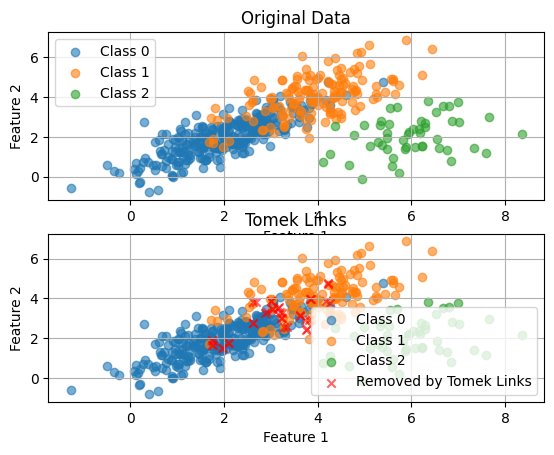

In [ ]:
from imblearn.under_sampling import TomekLinks

# Tomek Links 적용
tomek = TomekLinks()
X_tomek, y_tomek = tomek.fit_resample(df[["feature1", "feature2"]], df["TARGET"])

tomek_removed = df.merge(pd.DataFrame(X_tomek, columns=["feature1", "feature2"]), how="outer", indicator=True)
tomek_removed = tomek_removed[tomek_removed["_merge"] == "left_only"]

# 원본 데이터
plt.subplot(2, 1, 1)
for target_class in original_counts.keys():
    subset = df[df["TARGET"] == target_class]
    plt.scatter(subset["feature1"], subset["feature2"], label=f"Class {target_class}", alpha=0.6)
plt.title("Original Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)


# Tomek Links 데이터
plt.subplot(2,1, 2)
for target_class in np.unique(y_tomek):
    subset = pd.DataFrame(X_tomek, columns=["feature1", "feature2"])[y_tomek == target_class]
    plt.scatter(subset["feature1"], subset["feature2"], label=f"Class {target_class}", alpha=0.6)
plt.scatter(tomek_removed["feature1"], tomek_removed["feature2"], color="red", label="Removed by Tomek Links", alpha=0.6, marker='x')
plt.title("Tomek Links")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)

plt.show()

### Oversampling - ROS

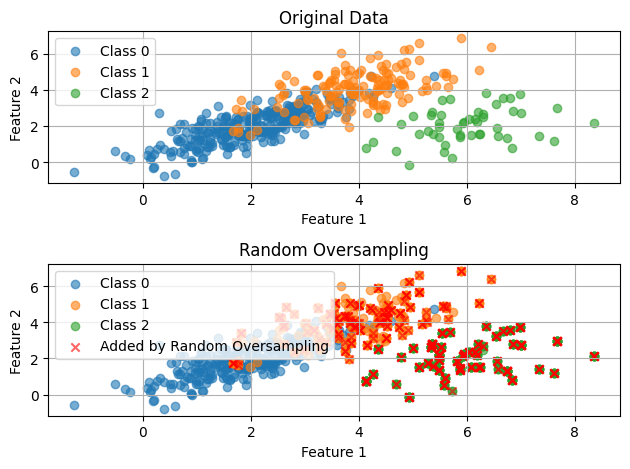

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Original class distribution
original_counts = Counter(df["TARGET"])

# Random Oversampling
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(df[["feature1", "feature2"]], df["TARGET"])
ros_added = pd.DataFrame(X_ros, columns=["feature1", "feature2"]).iloc[len(df):]

# Visualization for Random Oversampling
plt.subplot(2, 1, 1)
for target_class in original_counts.keys():
    subset = df[df["TARGET"] == target_class]
    plt.scatter(subset["feature1"], subset["feature2"], label=f"Class {target_class}", alpha=0.6)
plt.title("Original Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for target_class in np.unique(y_ros):
    subset = pd.DataFrame(X_ros, columns=["feature1", "feature2"])[y_ros == target_class]
    plt.scatter(subset["feature1"], subset["feature2"], label=f"Class {target_class}", alpha=0.6)
plt.scatter(ros_added["feature1"], ros_added["feature2"], color="red", label="Added by Random Oversampling", alpha=0.6, marker='x')
plt.title("Random Oversampling")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Oversampling - SMOTE

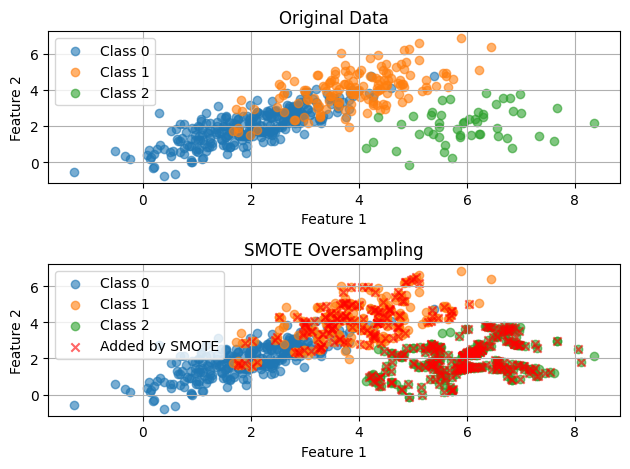

In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTE Oversampling
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(df[["feature1", "feature2"]], df["TARGET"])
smote_added = pd.DataFrame(X_smote, columns=["feature1", "feature2"]).iloc[len(df):]


# Visualization for SMOTE
plt.subplot(2, 1, 1)
for target_class in original_counts.keys():
    subset = df[df["TARGET"] == target_class]
    plt.scatter(subset["feature1"], subset["feature2"], label=f"Class {target_class}", alpha=0.6)
plt.title("Original Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for target_class in np.unique(y_smote):
    subset = pd.DataFrame(X_smote, columns=["feature1", "feature2"])[y_smote == target_class]
    plt.scatter(subset["feature1"], subset["feature2"], label=f"Class {target_class}", alpha=0.6)
plt.scatter(smote_added["feature1"], smote_added["feature2"], color="red", label="Added by SMOTE", alpha=0.6, marker='x')
plt.title("SMOTE Oversampling")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Oversampling - ADASYN

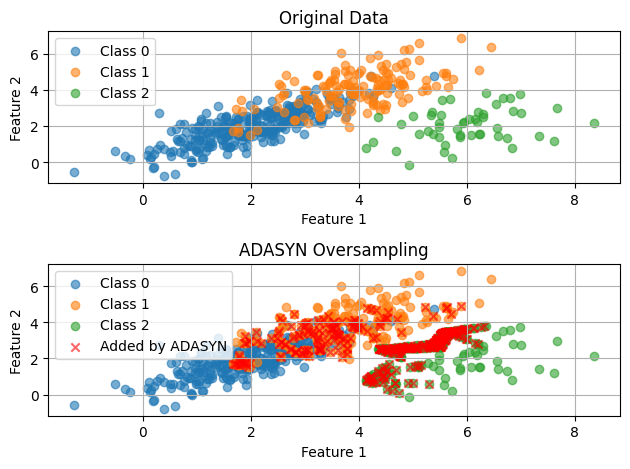

In [ ]:
from imblearn.over_sampling import ADASYN

# ADASYN Oversampling
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(df[["feature1", "feature2"]], df["TARGET"])
adasyn_added = pd.DataFrame(X_adasyn, columns=["feature1", "feature2"]).iloc[len(df):]


# Visualization for ADASYN
plt.subplot(2, 1, 1)
for target_class in original_counts.keys():
    subset = df[df["TARGET"] == target_class]
    plt.scatter(subset["feature1"], subset["feature2"], label=f"Class {target_class}", alpha=0.6)
plt.title("Original Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for target_class in np.unique(y_adasyn):
    subset = pd.DataFrame(X_adasyn, columns=["feature1", "feature2"])[y_adasyn == target_class]
    plt.scatter(subset["feature1"], subset["feature2"], label=f"Class {target_class}", alpha=0.6)
plt.scatter(adasyn_added["feature1"], adasyn_added["feature2"], color="red", label="Added by ADASYN", alpha=0.6, marker='x')
plt.title("ADASYN Oversampling")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Hybrid Method - SMOTEENN

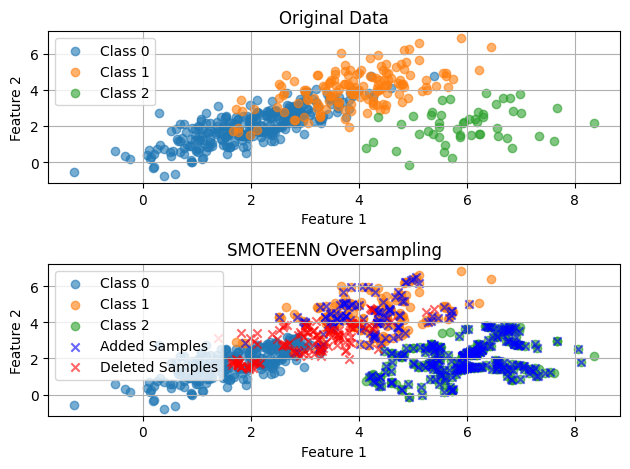

In [ ]:
from imblearn.combine import SMOTEENN

# Original class distribution
original_counts = Counter(df["TARGET"])

# SMOTEENN Oversampling
smoteenn = SMOTEENN(random_state=42)
X_smoteenn, y_smoteenn = smoteenn.fit_resample(df[["feature1", "feature2"]], df["TARGET"])

# Identify added and deleted data for SMOTEENN
smoteenn_all = pd.DataFrame(X_smoteenn, columns=["feature1", "feature2"])
smoteenn_deleted = df[~df[["feature1", "feature2"]].apply(tuple, axis=1).isin(smoteenn_all.apply(tuple, axis=1))]
smoteenn_added = smoteenn_all[~smoteenn_all.apply(tuple, axis=1).isin(df[["feature1", "feature2"]].apply(tuple, axis=1))]

# Visualization function
def visualize(title, original_df, processed_df, added_df, deleted_df):
    # Original data
    plt.subplot(2, 1, 1)
    for target_class in original_counts.keys():
        subset = original_df[original_df["TARGET"] == target_class]
        plt.scatter(subset["feature1"], subset["feature2"], label=f"Class {target_class}", alpha=0.6)
    plt.title("Original Data")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)

    # Processed data
    plt.subplot(2, 1, 2)
    for target_class in np.unique(processed_df["TARGET"]):
        subset = processed_df[processed_df["TARGET"] == target_class]
        plt.scatter(subset["feature1"], subset["feature2"], label=f"Class {target_class}", alpha=0.6)
    plt.scatter(added_df["feature1"], added_df["feature2"], color="blue", label="Added Samples", alpha=0.6, marker='x')
    plt.scatter(deleted_df["feature1"], deleted_df["feature2"], color="red", label="Deleted Samples", alpha=0.6, marker='x')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Visualize SMOTEENN
visualize("SMOTEENN Oversampling", df, smoteenn_all.assign(TARGET=y_smoteenn), smoteenn_added, smoteenn_deleted)

### Hybrid Method - SMOTETomek

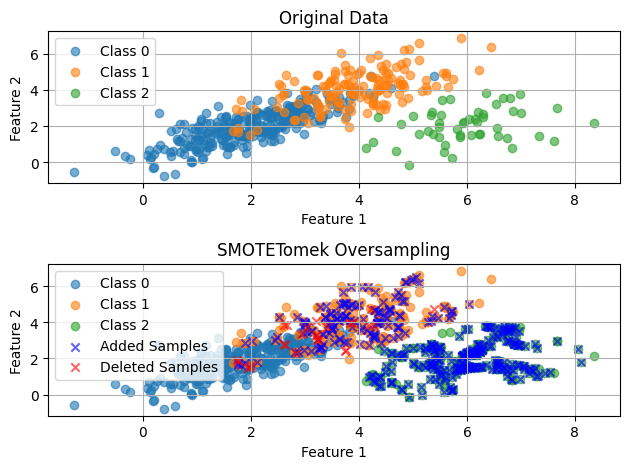

In [ ]:
from imblearn.combine import SMOTETomek

# SMOTETomek Oversampling
smotetomek = SMOTETomek(random_state=42)
X_smotetomek, y_smotetomek = smotetomek.fit_resample(df[["feature1", "feature2"]], df["TARGET"])

# Identify added and deleted data for SMOTETomek
smotetomek_all = pd.DataFrame(X_smotetomek, columns=["feature1", "feature2"])
smotetomek_deleted = df[~df[["feature1", "feature2"]].apply(tuple, axis=1).isin(smotetomek_all.apply(tuple, axis=1))]
smotetomek_added = smotetomek_all[~smotetomek_all.apply(tuple, axis=1).isin(df[["feature1", "feature2"]].apply(tuple, axis=1))]

# Visualize SMOTETomek
visualize("SMOTETomek Oversampling", df, smotetomek_all.assign(TARGET=y_smotetomek), smotetomek_added, smotetomek_deleted)


## 불균형 데이터 처리방법별 성능비교 실습

### 데이터 로딩 및 train/test 나누기

In [ ]:
# data split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# 지난수업에서 전처리한 csv파일 로딩
data = pd.read_csv('data_preprocessed.csv')

# Train/Test셋 데이터 분할 (stratify : y비율을 비슷하게 유지하는 층화추출출)
train , test = train_test_split(data, test_size = 0.1, random_state = 42, stratify = data['TARGET'])

### 성능비교 : Vanilla(별도 처리하지 않음)

* RandomForestClassifier 활용
* 아래 코드에서 사용된 predict_proba() : predict가 확률계산 후 확률에 따라 속하는 y를 산출했다면, predict_proba는 확률까지만 계산
  * AUC를 계산하기 위해 사용함 (Imbalance data는 단순히 accuracy로 평가할 수 없음)
  * AUC/ROC 이해를 돕기위한 움직이는 그래프 자료 : https://angeloyeo.github.io/2020/08/05/ROC.html

In [ ]:
X_vanila = train.drop(['TARGET'], axis = 1)
y_vanila = train['TARGET']

In [ ]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf_vanila = RandomForestClassifier(random_state = 42)
rf_vanila.fit(X_vanila, y_vanila)

y_vanila_pred = rf_vanila.predict(test.drop(['TARGET'], axis = 1))
y_vanila_proba = rf_vanila.predict_proba(test.drop(['TARGET'], axis = 1)) # predict_proba : 0.5보다 높고 낮음까지 계산하지말고, 그전의 확률까지만계산

y_test = test['TARGET']

CPU times: total: 32.3 s
Wall time: 1min 54s


In [ ]:
vanila_accuracy = accuracy_score(y_test, y_vanila_pred)
vanila_cf = confusion_matrix(y_test, y_vanila_pred)
vanila_roc_auc = roc_auc_score(y_test, y_vanila_proba[:,1])

print(f"* Vanila_accuracy : {vanila_accuracy}")
print(f"* Vanila_roc_auc{vanila_roc_auc}")
print(f"* Vanila_confusion materix :\n {vanila_cf}")

* Vanila_accuracy : 0.9193223204994797
* Vanila_roc_auc0.7084669152907
* Vanila_confusion materix :
 [[28266     3]
 [ 2478     5]]


### 심화 1 : Rapids

* sklearn은 GPU미지원 시기에 개발되어, sklearn의 RandomForest는 GPU연산 미지원 
  * XGB나 LGBM은 지원 (XGB의 RandomForest는 지원원)
* GPU연산 미지원 라이브러리를 GPU연산 하고싶을 때, RAPIDS라이브러리의 `cuml` 사용 가능
  * cuml은 이외에도 다양한 sklearn의 기능을 대체 가능

* RAPIDS 설치
  * CUDA버전을 먼저 확인
    ```
    !nvcc --version
    ```
  * 공식git(설치법 등) : https://github.com/rapidsai/cuml?tab=readme-ov-file
  * the RAPIDS Release Selector : https://docs.rapids.ai/install/#selector
    * 환경에 맞춰 선택하면, 아래와 같이 Command가 생성됨
      ```
        pip install \
            --extra-index-url=https://pypi.nvidia.com \
            "cudf-cu12==24.12.*" "dask-cudf-cu12==24.12.*" "cuml-cu12==24.12.*" \
            "cugraph-cu12==24.12.*" "nx-cugraph-cu12==24.12.*" "cuspatial-cu12==24.12.*" \
            "cuproj-cu12==24.12.*" "cuxfilter-cu12==24.12.*" "cucim-cu12==24.12.*" \
            "pylibraft-cu12==24.12.*" "raft-dask-cu12==24.12.*" "cuvs-cu12==24.12.*" \
            "nx-cugraph-cu12==24.12.*"
      ```

* RAPIDS `cuml` 사용 예시
    ```
    from cuml.ensemble import RandomForestClassifier as cuml_RandomForestClassifier

    rf_vanila_rapid = cuml_RandomForestClassifier(random_state=42)
    rf_vanila_rapid.fit(X_vanila, y_vanila)
    y_vanila_rapid_pred = rf_vanila_rapid.predict(test.drop(['TARGET'], axis = 1))
    y_vanila_rapid_proba = rf_vanila_rapid.predict_proba(test.drop(['TARGET'], axis = 1))
    y_test = test['TARGET']
    ```

* CUDA버전확인 샘플

In [ ]:
# CUDA버전확인 샘플
!nvcc --version

* cuml의 RandomForestClassifier 샘플

In [ ]:
%%time
from cuml.ensemble import RandomForestClassifier as cuml_RandomForestClassifier

rf_vanila_rapid = cuml_RandomForestClassifier(random_state=42)
rf_vanila_rapid.fit(X_vanila, y_vanila)
y_vanila_rapid_pred = rf_vanila_rapid.predict(test.drop(['TARGET'], axis = 1))
y_vanila_rapid_proba = rf_vanila_rapid.predict_proba(test.drop(['TARGET'], axis = 1))
y_test = test['TARGET']

### 성능비교 : RUS

* Wall time: 1min 54s  →  16.2 s

* Vanila_accuracy : 0.9193223204994797  → 0.694686524453694
* Vanila_roc_auc0.7084669152907  → 0.7370645914878501
* Vanila_confusion materix :
 [[28266     3]      →     [[19723  8546]
 [ 2478     5]]      →     [  843  1640]]

In [ ]:
%%time
from imblearn.under_sampling import RandomUnderSampler

# RUS 적용
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(train.drop(['TARGET'], axis = 1), train["TARGET"])
X_rus.shape

CPU times: total: 156 ms
Wall time: 513 ms


(44684, 131)

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf_rus = RandomForestClassifier(random_state = 42)
rf_rus.fit(X_rus, y_rus)
y_rus_pred = rf_rus.predict(test.drop(['TARGET'], axis = 1))
y_rus_proba = rf_rus.predict_proba(test.drop(['TARGET'], axis = 1))
y_test = test['TARGET']

CPU times: total: 4.41 s
Wall time: 16.2 s


In [ ]:
rus_accuracy = accuracy_score(y_test, y_rus_pred)
rus_cf = confusion_matrix(y_test, y_rus_pred)
rus_roc_auc = roc_auc_score(y_test, y_rus_proba[:,1])

sampling_method = 'RUS'
print(f"* {sampling_method}_accuracy : {rus_accuracy}")
print(f"* {sampling_method}_roc_auc : {rus_roc_auc}")
print(f"*{sampling_method}_confusion materix :\n {rus_cf}")

* RUS_accuracy : 0.694686524453694
* RUS_roc_auc : 0.7370645914878501
*RUS_confusion materix :
 [[19723  8546]
 [  843  1640]]


* 함수화 (이후부터 함수로 진행)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score


def compute_for_samplers(train, test, sampler, return_metric_only= False):
  X_sampled, y_sampled = sampler.fit_resample(train.drop(['TARGET'], axis = 1), train["TARGET"])
  model = RandomForestClassifier(random_state = 42)
  model.fit(X_sampled, y_sampled)
  y_pred = model.predict(test.drop(['TARGET'], axis = 1))
  y_proba = model.predict_proba(test.drop(['TARGET'], axis = 1))
  y_test = test['TARGET']

  accuracy = accuracy_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_proba[:,1])
  cf = confusion_matrix(y_test, y_pred)
  if return_metric_only:
    return accuracy, cf, auc
  else:
    return {'acc':accuracy,
            'auc':auc,
            'cf':cf,
            'X_sampled' : X_sampled,
            'y_sampled' : y_sampled,
            'model' : model,
            'y_pred' : y_pred,
            'y_proba' : y_proba}

### 성능비교 : ENN

* 요약
  * 시간이 더 오래걸리고, 성능 도움도 되지 않았음
  * 비율을 맞춰주는 알고리즘이 아니고, 연산시간이 길어짐

* Wall time: 1min 54s  →  3min 37s

* Vanila_accuracy : 0.9193223204994797  → 0.9192572840790842
* Vanila_roc_auc : 0.7084669152907  → 0.7138916844382973
* Vanila_confusion materix :
 [[28266     3]      →     [[28240    29]
 [ 2478     5]]      →     [ 2454    29]]

In [ ]:
%%time

from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours()
enn_result = compute_for_samplers(train, test, enn)

print(enn_result['acc'])
print(enn_result['auc'])
print(enn_result['cf'])

0.9192572840790842
0.7138916844382973
[[28240    29]
 [ 2454    29]]
CPU times: total: 6min 13s
Wall time: 3min 37s


* Imbalance를 적절히 제거했다면, y에 맞춰 2만여개의 데이터가 남아있어야 함
* 실제로는 22만개가 남아있는데, ENN은 비율을 맞추는 알고리즘이 아닌 이상한 것(노이즈)을 걸러내기 때문
* k값을 늘릴수록 없애는 값이 늘어남(knn기반이므로로)

In [ ]:
# X_train 샘플 차이
print(f"""* ENN전 : {train.shape}
* ENN후 : "{enn_result['X_sampled'].shape}""")

* ENN전 : (276759, 132)
* ENN후 : "(221430, 131)


In [ ]:
# y_train 값 분포
print(f"""
* ENN 전
{train.groupby('TARGET').size()}

* ENN 후
{enn_result['y_sampled'].value_counts()}""")


* ENN 전
TARGET
0    254417
1     22342
dtype: int64

* ENN 후
TARGET
0    199088
1     22342
Name: count, dtype: int64


### 성능비교 : Tomek-Links

* 요약
  * 오래 걸리고, 성능도 개선되지 않음

* Wall time: 1min 54s  →  4min 8s

* Vanila_accuracy : 0.9193223204994797  → 0.9194198751300728
* Vanila_roc_auc : 0.7084669152907  → 0.7135753731337223
* Vanila_confusion materix :
 [[28266     3]      →     [[28266     3]
 [ 2478     5]]      →      [ 2475     8]]

In [ ]:
%%time

from imblearn.under_sampling import TomekLinks

tml = TomekLinks()
tml_result = compute_for_samplers(train, test, tml)

print(tml_result['acc'])
print(tml_result['auc'])
print(tml_result['cf'])

0.9194198751300728
0.7135753731337223
[[28266     3]
 [ 2475     8]]
CPU times: total: 7min 37s
Wall time: 4min 8s


In [ ]:
# X_train 샘플 차이
print(f"""* TomekLinks 전 : {train.shape}
* TomekLinks 후 : "{tml_result['X_sampled'].shape}""")

* TomekLinks 전 : (276759, 132)
* TomekLinks 후 : "(266325, 131)


In [ ]:
# y_train 값 분포
print(f"""
* TomekLinks 전
{train.groupby('TARGET').size()}

* TomekLinks 후
{tml_result['y_sampled'].value_counts()}""")


* TomekLinks 전
TARGET
0    254417
1     22342
dtype: int64

* TomekLinks 후
TARGET
0    243983
1     22342
Name: count, dtype: int64


### 성능비교 : ROS

* Wall time: 1min 54s  →  3min 4s

* Vanila_accuracy : 0.9193223204994797  → 0.919062174817898
* Vanila_roc_auc : 0.7084669152907  → 0.7287776769542174
* Vanila_confusion materix :
 [[28266     3]      →     [[28223    46]
 [ 2478     5]]      →       [ 2443    40]]

In [ ]:
%%time

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
ros_result = compute_for_samplers(train, test, ros)

print(ros_result['acc'])
print(ros_result['auc'])
print(ros_result['cf'])

0.919062174817898
0.7287776769542174
[[28223    46]
 [ 2443    40]]
CPU times: total: 1min 1s
Wall time: 3min 4s


In [ ]:
# X_train 샘플 차이
print(f"""* ROS 전 : {train.shape}
* ROS 후 : {ros_result['X_sampled'].shape}""")

* ROS 전 : (276759, 132)
* ROS 후 : (508834, 131)


In [ ]:
# y_train 값 분포
print(f"""
* ROS 전
{train.groupby('TARGET').size()}

* ROS 후
{ros_result['y_sampled'].value_counts()}""")


* ROS 전
TARGET
0    254417
1     22342
dtype: int64

* ROS 후
TARGET
0    254417
1    254417
Name: count, dtype: int64


### 성능비교 : SMOTE

* Wall time: 1min 54s  →  3min 23s

* Vanila_accuracy : 0.9193223204994797  → 0.9192572840790842
* Vanila_roc_auc : 0.7084669152907  → 0.6958898421466617
* Vanila_confusion materix :
 [[28266     3]      →     [[28268     1]
 [ 2478     5]]      →        [ 2482     1]]

In [ ]:
%%time
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
smote_result = compute_for_samplers(train, test, smote)

print(smote_result['acc'])
print(smote_result['auc'])
print(smote_result['cf'])

0.9192572840790842
0.6958898421466617
[[28268     1]
 [ 2482     1]]
CPU times: total: 1min 16s
Wall time: 3min 23s


In [ ]:
# X_train 샘플 차이
print(f"""* SMOTE 전 : {train.shape}
* SMOTE 후 : "{smote_result['X_sampled'].shape}""")

* SMOTE 전 : (276759, 132)
* SMOTE 후 : "(508834, 131)


In [ ]:
# y_train 값 분포
print(f"""
* SMOTE 전
{train.groupby('TARGET').size()}

* SMOTE 후
{smote_result['y_sampled'].value_counts()}""")


* SMOTE 전
TARGET
0    254417
1     22342
dtype: int64

* SMOTE 후
TARGET
0    254417
1    254417
Name: count, dtype: int64


### 성능비교 결과

* imblearn의 성능개선에 비해 들어가는 노력(시간)이 큼
* 데이터 사이즈와 변수가 적었던 과거와 달리, 유의미한 결과를 내지 못하게 되었음
* 어느정도 비율을 맞추는데 사용되고, class weights를 통한 가중치 조절에 자리를 내어줌

In [ ]:
# 이제 모델 성능 비교
# 선형 회귀 vs SVR vs RFR
# 로지스틱회귀 vs svc vs RFC
# RFC vs XGBC vs LGBMC vs CATBOOSTC vs EXTRATREEC

## Model별 성능 비교 실습

* SVM의 실행시간문제로 데이터 사이즈를 줄여서 실습

### 라이브러리 설치 및 데이터 분할

In [ ]:
!pip install catboost xgboost lightgbm
# 라이브러리 설치

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import time

train_, _  = train_test_split(train, random_state = 42, test_size = 0.9)
train_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27675 entries, 105024 to 224936
Columns: 132 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_nan
dtypes: float64(89), int64(43)
memory usage: 28.1 MB


### 모델 성능 비교

In [ ]:
# 모델 리스트
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "SVC": SVC(class_weight="balanced", probability = True, random_state=42),
    "LightGBM": LGBMClassifier(class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=10, eval_metric="logloss", random_state=42),
    "CatBoost": CatBoostClassifier(class_weights=[1, 10], verbose=0, random_state=42),
    "Extra Trees": ExtraTreesClassifier(class_weight="balanced", random_state=42),
}

X_train = train_.drop(['TARGET'], axis = 1)
y_train = train_['TARGET']
X_test = test.drop(['TARGET'], axis = 1)
y_test = test['TARGET']
rsts = {}
# 학습 및 평가
for name, model in models.items():
    print(f"\n{name}")
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba[:,1])
    cf = confusion_matrix(y_test, y_pred)
    rsts[name] = {'acc':accuracy,
                  'auc':auc,
                  'cf':cf,
                  'model' : model,
                  'y_pred' : y_pred,
                  'y_proba' : y_proba,
                  'time' : time.time() - start }
    
    print(f"""
{classification_report(y_test, y_pred)}""")


Random Forest

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28269
           1       0.50      0.00      0.00      2483

    accuracy                           0.92     30752
   macro avg       0.71      0.50      0.48     30752
weighted avg       0.89      0.92      0.88     30752


SVC

              precision    recall  f1-score   support

           0       0.94      0.53      0.67     28269
           1       0.10      0.60      0.17      2483

    accuracy                           0.53     30752
   macro avg       0.52      0.56      0.42     30752
weighted avg       0.87      0.53      0.63     30752


LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2199, number of negative: 25476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

In [ ]:
# 파일로 저장
import pickle
with open('rsts.pkl', 'wb') as f:
  pickle.dump(rsts, f)

In [ ]:
df_results = pd.DataFrame(rsts).loc[['acc','auc','cf','time'],:]
df_results

,Random Forest,SVC,LightGBM,XGBoost,CatBoost,Extra Trees
acc,0.919257,0.531835,0.779429,0.846839,0.839588,0.91916
auc,0.707628,0.596337,0.736252,0.703948,0.735909,0.689785
cf,"[[28266, 3], [2480, 3]]","[[14872, 13397], [1000, 1483]]","[[22670, 5599], [1184, 1299]]","[[25235, 3034], [1676, 807]]","[[24872, 3397], [1536, 947]]","[[28266, 3], [2483, 0]]"
time,9.124638,762.844463,0.5796,0.665159,9.372309,5.709153


* **LGBM으로 Model selection**
  * AUC기준 LGBM(0.736252), CatBoost(0.735909) 순으로 좋음
  * CF기준 LightGBM과 XGBoost는 Tradeoff가 있음
    * LightGBM과는 실제 1인 데이터를 잘 찾고(1299), XGBoost는 1이 아닌데 1로 분류하는 경우가 적다(3034)
    * 과제의 성격에 따라 모델을 선택
  * Time기준 LGBM과 XGBoost가 빠름
  * **현재 과제는 실제 1을 찾아내는 것이 중요하다는 관점으로, LGBM선택**

## Model selection 후 케이스별 비교

* 비교할 2가지 Case
  * **LightGBM** with RUS
  * **LightGBM**(Weighted) with**out** RUS
* Weight에 대한 설정방법은 모델별로 다름
  ```python
    models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced"),
    "SVC": SVC(class_weight="balanced", probability = True),
    "LightGBM": LGBMClassifier(class_weight="balanced"),
    "XGBoost": XGBClassifier(scale_pos_weight=10, eval_metric="logloss"),
    "CatBoost": CatBoostClassifier(class_weights=[1, 10], verbose=0),
    "Extra Trees": ExtraTreesClassifier(class_weight="balanced"),
    }
  ```

In [ ]:
# Base model with RUS
X_train_rus, y_train_rus = X_rus, y_rus

rus_model = LGBMClassifier(random_state=42).fit(X_train_rus, y_train_rus)
y_pred_rus = rus_model.predict(X_test)
y_proba_rus = rus_model.predict_proba(X_test)

accuracy_rus = accuracy_score(y_test, y_pred_rus)
auc_rus = roc_auc_score(y_test, y_proba_rus[:,1])
cf_rus = confusion_matrix(y_test, y_pred_rus)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 22342, number of negative: 22342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11024
[LightGBM] [Info] Number of data points in the train set: 44684, number of used features: 121
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [ ]:
# Weight model without RUS
weights_model = LGBMClassifier(random_state=42, class_weight='balanced').fit(X_train, y_train)
y_pred_weights = weights_model.predict(X_test)
y_proba_weights = weights_model.predict_proba(X_test)

accuracy_weights = accuracy_score(y_test, y_pred_weights)
auc_weights = roc_auc_score(y_test, y_proba_weights[:,1])
cf_weights = confusion_matrix(y_test, y_pred_weights)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2199, number of negative: 25476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10852
[LightGBM] [Info] Number of data points in the train set: 27675, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


In [ ]:
# Base model with RUS
print(f'accuracy of LGBM with RUS : {round(accuracy_rus,4)}')
print(f'auc of LGBM with RUS : {round(auc_rus,4)}')
print('-'*100)
print('CF of LGBM With RUS')
print(cf_rus)

accuracy of LGBM with RUS : 0.6924
auc of LGBM with RUS : 0.7565
----------------------------------------------------------------------------------------------------
CF of LGBM With RUS
[[19587  8682]
 [  777  1706]]


In [ ]:
# Weight model without RUS
print(f'accuracy of LGBM with Class Weight : {round(accuracy_weights,4)}')
print(f'auc of LGBM with Class Weight : {round(auc_weights,4)}')
print('-'*100)
print('CF of LGBM With Class Weight')
print(cf_weights)

accuracy of LGBM with Class Weight : 0.7794
auc of LGBM with Class Weight : 0.7363
----------------------------------------------------------------------------------------------------
CF of LGBM With Class Weight
[[22670  5599]
 [ 1184  1299]]


* 결과 비교 및 선택
  * Test데이터에 대해 강건(Robust)한 모델은, 데이터를 많이 본 모델
  * 특히 장기적으로 쓴다면 더 많은 데이터를 본 강건한 모델이 더 유지하기 쉬움
  * 위 기준으로는 후자의 모델(Weight model without RUS)을 선택
* 참고
  * 현재의 모델도 100% 완벽하다고는 볼 수 없으나, 연체 위험자 등을 찾아낼 수 있다는 점에서 의의
  * Hybrid method를 실제로 쓸 일은 잘 없음(SMOTE의 오버피팅 문제로)

# 과제

1) Week3 과제에서 전처리 완료된 데이터를 가지고, Week4에 배운 다양한 불균형 처리 기법을 시험해보세요.
2) 1)에서 결정된 불균형 처리 방법을 기준으로 최종 Model을 결정해 보세요.